## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb
import catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'


**Загрузка данных**

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [7]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
df_test.shape

(2500, 16)

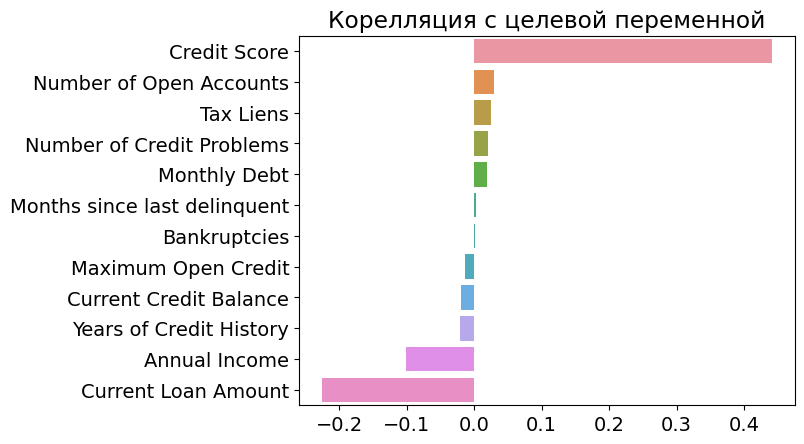

In [10]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корелляция с целевой переменной')
plt.show()

In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


**Преобразуем типы данных:**

Сначала на трейне:

In [12]:
df_train['Home Ownership'] = df_train['Home Ownership'].astype(str)
df_train['Purpose'] = df_train['Purpose'].astype(str)
df_train['Term'] = df_train['Term'].astype(str)
df_train['Years in current job'] = df_train['Years in current job'].astype(str)

In [13]:
df_train['Years in current job'] = pd.to_numeric(df_train['Years in current job'].str.extract(r"\b(\d+)\b")[0], errors="coerce")

In [14]:
df_train['Years in current job'] = df_train['Years in current job'].astype('int', errors='ignore')

Теперь на тесте:

In [15]:
df_test['Home Ownership'] = df_test['Home Ownership'].astype(str)
df_test['Purpose'] = df_test['Purpose'].astype(str)
df_test['Term'] = df_test['Term'].astype(str)
df_test['Years in current job'] = df_test['Years in current job'].astype(str)

In [16]:
df_test['Years in current job'] = pd.to_numeric(df_test['Years in current job'].str.extract(r"\b(\d+)\b")[0], errors="coerce")

In [17]:
df_test['Years in current job'] = df_test['Years in current job'].astype('int', errors='ignore')

**Обработка аномалий**

*Количественные признаки:*

In [18]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Years in current job,2414.0,6.035626e+00,3.504596e+00,1.0,3.00,6.0,10.0,10.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0


In [19]:
#Функция построения графиков зависимостей
def grafik(target_name):
    plt.figure(figsize=(20,8))
    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df_test[target_name].hist()
    plt.subplot(122)
    probplot(df_test[target_name],dist='norm',plot=plt)
    plt.show()
    
# функция замены пропусков медианным значением
def median_func(target_name):
    df_train[target_name].fillna(df_train[target_name].median(), inplace=True)

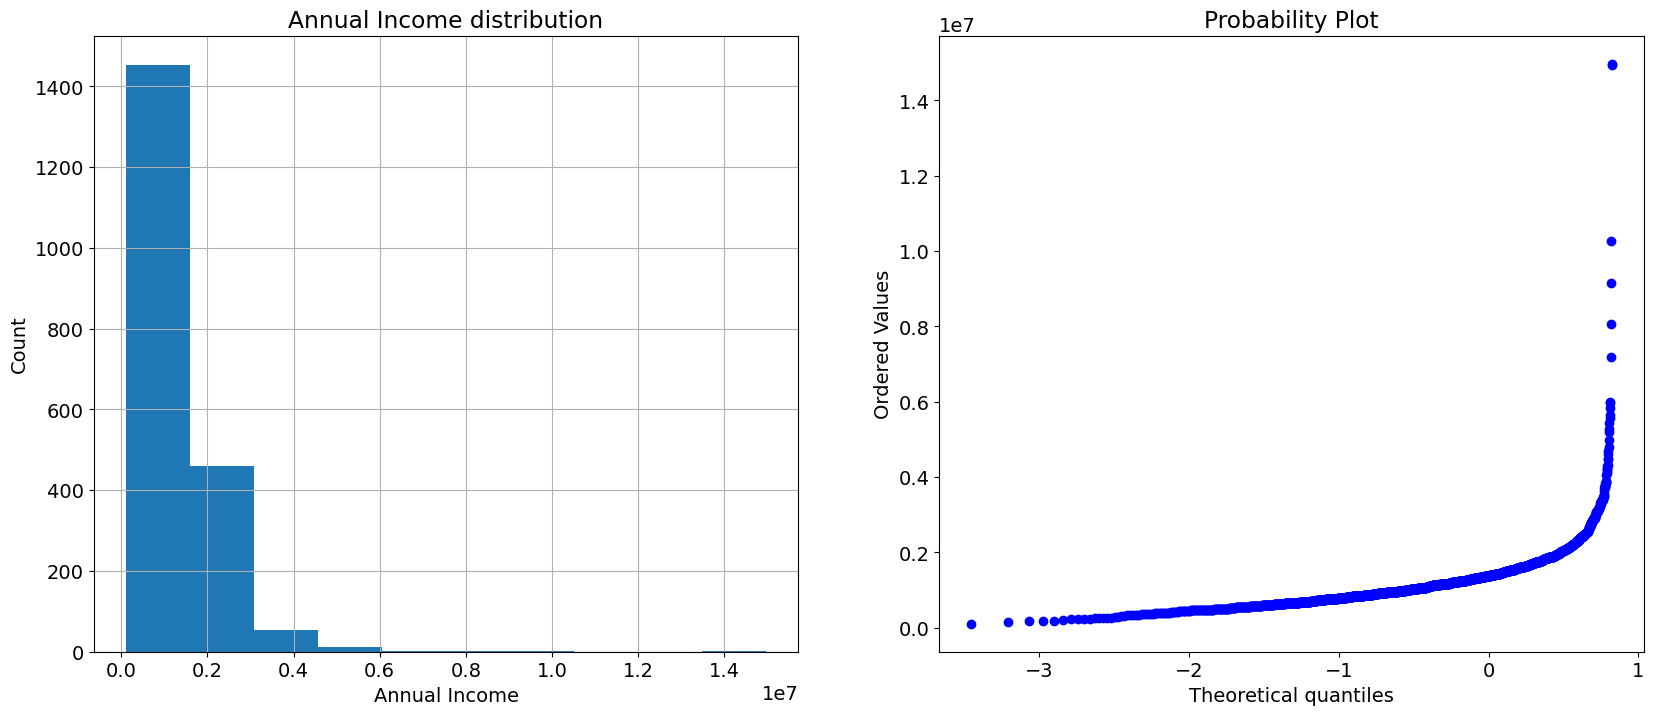

In [20]:
median_func('Annual Income')
grafik('Annual Income') # годовой доход

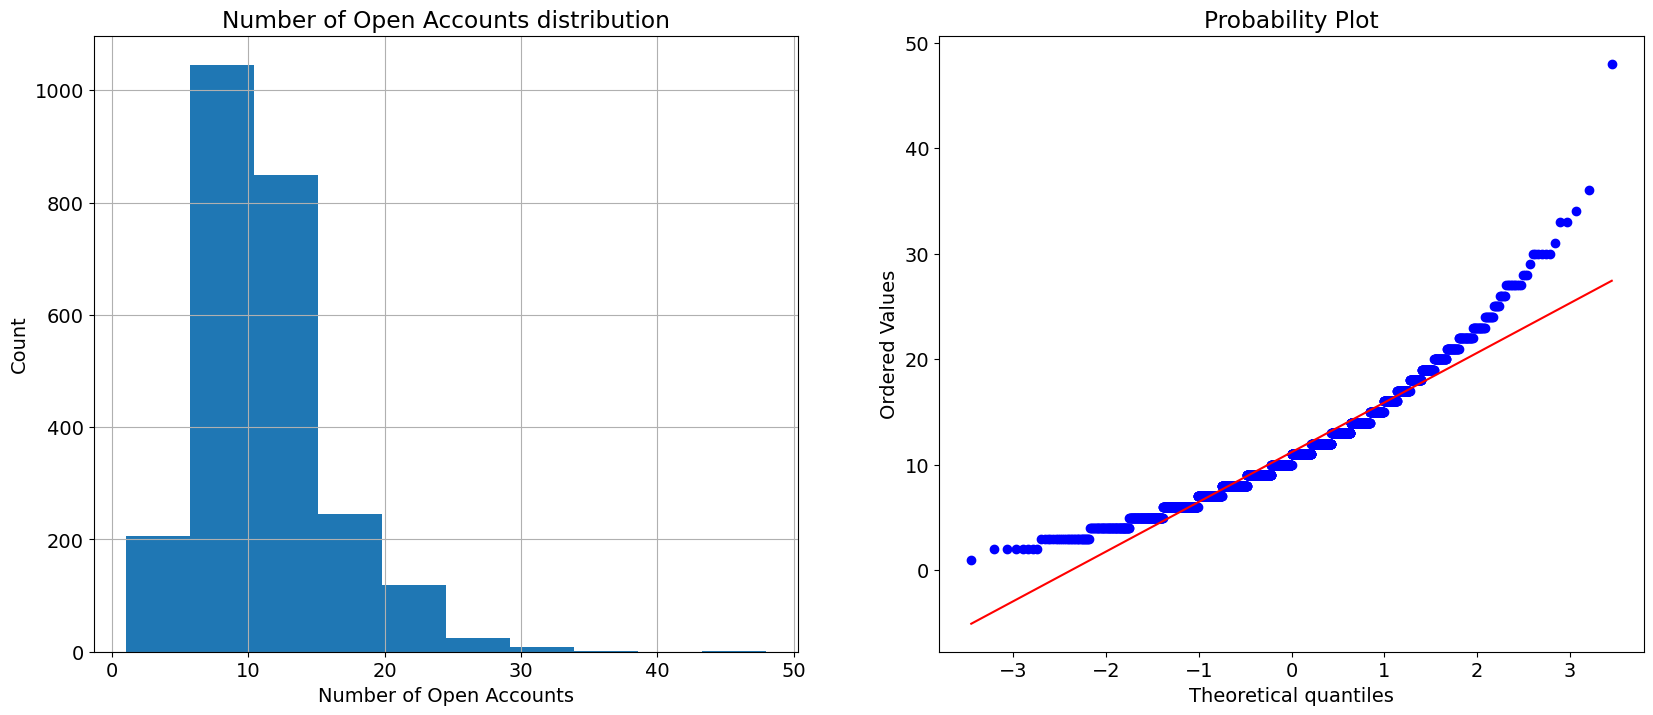

In [21]:
median_func('Number of Open Accounts')
grafik('Number of Open Accounts') # количество проблем с кредитом

Возможно что все что свыше 20 - 30 это выбросы.

In [22]:
df_train[df_train['Number of Open Accounts'] > 25].head(10).T

,305,342,423,464,658,918,940,953,967,1083
Home Ownership,Rent,Home Mortgage,Home Mortgage,Rent,Home Mortgage,Rent,Own Home,Home Mortgage,Rent,Own Home
Annual Income,1168386.0,1168386.0,1277161.0,1246248.0,2031708.0,1144560.0,1091436.0,1319645.0,1168386.0,2316024.0
Years in current job,1.0,6.0,NaN,10.0,1.0,6.0,7.0,8.0,10.0,4.0
Tax Liens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,32.0,33.0,32.0,31.0,30.0,29.0,28.0,26.0,30.0,28.0
Years of Credit History,9.0,15.5,15.4,18.4,16.7,16.6,16.7,20.2,19.2,15.3
Maximum Open Credit,96668.0,2369664.0,392722.0,2366496.0,2925120.0,852918.0,1740244.0,1124156.0,647900.0,681824.0
Number of Credit Problems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Months since last delinquent,75.0,15.0,NaN,NaN,NaN,1.0,NaN,35.0,47.0,41.0
Bankruptcies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def median_emissions(target_name):
    median = df_train[target_name].median()
    std = df_train[target_name].std()
    outliers = (df_train[target_name] - median).abs() > std
    df_train[outliers] = np.nan
    df_train=df_train[target_name].fillna(median, inplace=True)

In [28]:
median_emissions('Number of Open Accounts')
grafik('Number of Open Accounts') # количество проблем с кредитом

UnboundLocalError: local variable 'df_train' referenced before assignment

Ситуация сильно не изменилась.

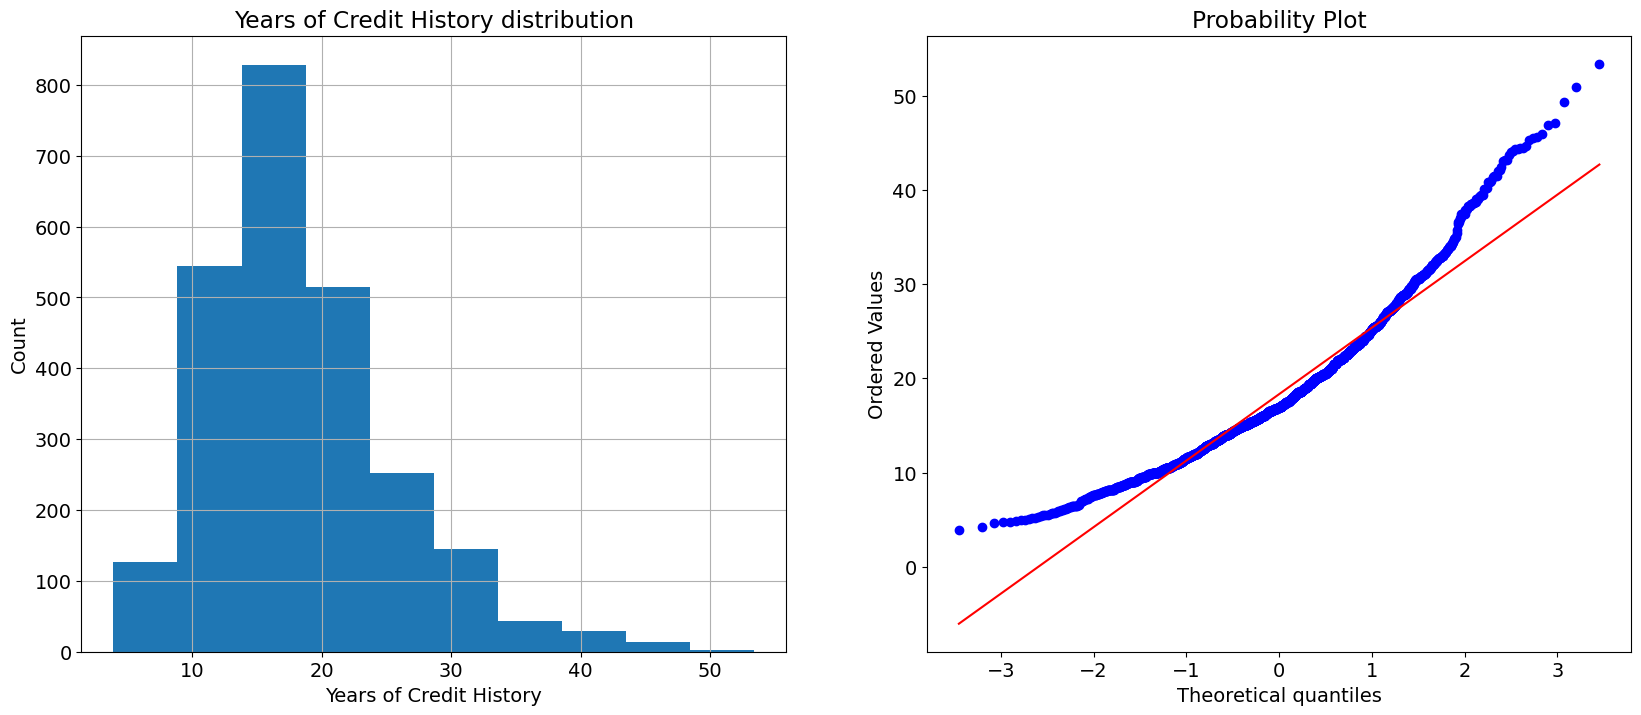

In [25]:
grafik('Years of Credit History') # количество лет кредитной истории

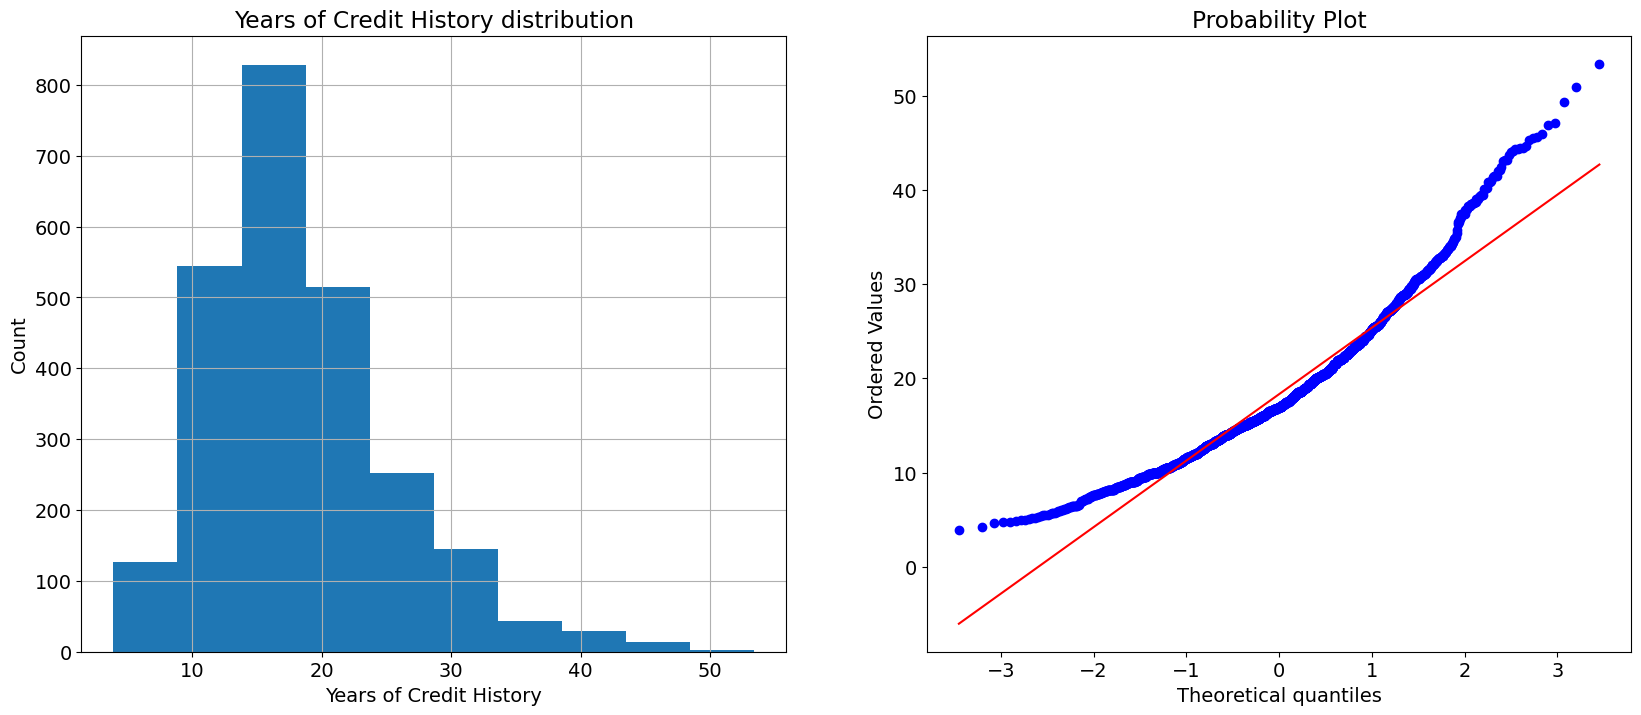

In [26]:
df_train = df_train[df_train['Years of Credit History'] < 45]
grafik('Years of Credit History')